# Final project

In [1]:
#导入所需包
import csv
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [2]:
#导入数据并进行特征选择
# Document: kc_house_data
df = pandas.read_csv('Original Data/kc_house_data.csv')
# Document: melb_data
#df = pandas.read_csv('Original Data/melb_data.csv')

# Document: kc_house_data
feature = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors',
              'view','condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long']]
# Document: melb_data
#feature = df[['Rooms','Bedroom2','Bathroom','Distance','Landsize','BuildingArea','YearBuilt', 'Car', 'Lattitude', 'Longtitude']]
feature.fillna(feature.mean(), inplace=True)

# Document: kc_house_data
price = df[['price']]
# Document: melb_data
#price = df[['Price']]
price.fillna(price.mean(), inplace=True)

/Users/winton/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [3]:
#本次项目主要分为以下几个部分：
# (1)数据分析可视化部分
# (2)数据预处理部分
# (3)模型训练和预测
# (4)结果分析
# (5)总结

In [4]:
#1.数据分析可视化部分

In [5]:
#查看相关数据
min_price = np.min(price)
max_price = np.max(price)
mean_price = np.mean(price)
median_price = np.median(price)
std_price = np.std(price)
print (f"Statistics for Boston housing dataset:{min_price}\n")
print (f"min_price: {min_price}")
print (f"max_price: {max_price}")
print (f"mean_price :{mean_price}")
print (f"median_price:{median_price}")
print (f"std_price: {std_price}")

Statistics for Boston housing dataset:price    75000.0
dtype: float64

min_price: price    75000.0
dtype: float64
max_price: price    7700000.0
dtype: float64
mean_price :price    540088.141767
dtype: float64
median_price:450000.0
std_price: price    367118.703181
dtype: float64


In [6]:
#2.数据预处理部分
def detect_outliers(df,n,features):

    outlier_indices = []

    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

        # multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)
        outlier_indices.extend(outlier_list_col)
        x = np.array(outlier_list_col)
        print(len(x))
    return outlier_list_col
Outliers_to_drop = detect_outliers(df, 2, ['price'])
df = df.drop(Outliers_to_drop, axis=0).reset_index(drop=True)
Outliers_to_drop = detect_outliers(df, 2, ['price'])


1146
264


In [7]:
#3.模型训练和预测

X = np.array(feature)
y = np.array(price)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, train_size=0.70, shuffle=True)

In [8]:
# 备用代码
# model = LinearRegression()
# model.fit(X_train,y_train)

# yhat_1 = model.predict(X_test)
# score_1 = r2_score(y_test, yhat_1)
# print('Model score is ', score_1)
# print ('The mean squared error is: ', mean_squared_error(y_test, yhat_1))


R2:  0.6965422541449432
r2_score =  [0.7201807  0.69123638 0.70017506 0.68212367 0.68686404]
r2_score_average =  0.6961159681051651


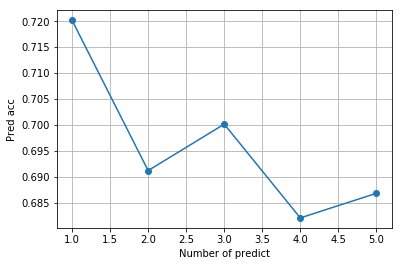

In [9]:
#模型一：线性回归模型

LinearRegression_model = LinearRegression()
LinearRegression_model.fit(X_train, y_train)

yhat = LinearRegression_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(LinearRegression_model, X_test, y_test.ravel(), cv=kf)

print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

#画图
#plt.scatter(np.arange(1, 6), score_ndarray)
plt.xlabel('Number of predict')
plt.ylabel('Pred acc')

#ymin = np.min(y_test)
#ymax = np.max(y_test)
plt.plot(np.arange(1, 6), score_ndarray, "o-")
plt.grid()
plt.show()

In [10]:
#模型二：决策树回归模型
#使用决策树回归模型做回归预测，并使用交叉验证查看模型得分。
#调用sklearn.tree库的DecisionTreeRegressor方法实例化模型对象。
#调用sklearn.model_selection库的KFold方法实例化交叉验证对象。
#调用sklearn.model_selection库的cross_val_score方法做交叉验证。

DecisionTree_model = DecisionTreeRegressor()
DecisionTree_model.fit(X_train, y_train)

yhat = DecisionTree_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(DecisionTree_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

R2:  -1.0395818587726269
r2_score =  [0.63020231 0.70401286 0.65862171 0.66687351 0.6563936 ]
r2_score_average =  0.6632207981132409


In [11]:
#模型三：随机森林回归模型
#使用随机森林回归模型做回归预测，并使用交叉验证查看模型得分。
#调用sklearn.ensemble库的RandonForestRegressor方法实例化模型对象。
#调用sklearn.model_selection库的KFold方法实例化交叉验证对象。
#调用sklearn.model_selection库的cross_val_score方法做交叉验证。

randomForest_model = RandomForestRegressor()
randomForest_model.fit(X_train, y_train)

yhat = randomForest_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(randomForest_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

/Users/winton/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/winton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


R2:  -0.8928217814111128
r2_score =  [0.82183466 0.75740792 0.80510748 0.83419382 0.8141608 ]
r2_score_average =  0.8065409359312599


In [12]:
#模型四：极限🌲回归模型
#使用极限🌲回归模型做回归预测，并使用交叉验证查看模型得分。
#调用sklearn.ensemble库的ExtraTreesRegressor方法实例化模型对象。
#调用sklearn.model_selection库的KFold方法实例化交叉验证对象。
#调用sklearn.model_selection库的cross_val_score方法做交叉验证。

ExtraTrees_model = ExtraTreesRegressor()
ExtraTrees_model.fit(X_train, y_train)

yhat = ExtraTrees_model.predict(X_test)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(ExtraTrees_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

/Users/winton/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/winton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


R2:  -0.9018814702950189
r2_score =  [0.76798781 0.77424988 0.81679423 0.82346257 0.8213801 ]
r2_score_average =  0.8007749184752125


In [13]:
#模型五：梯度增强回归模型

GradientBoostingRegressor_model = GradientBoostingRegressor(n_estimators = 400, min_samples_split = 2,
         learning_rate = 0.1, loss = 'ls')
GradientBoostingRegressor_model.fit(X_train, y_train)

yhat = GradientBoostingRegressor_model.predict(X_test)
print(yhat)
R2 = 1 - np.mean((y_test-yhat)**2)/(np.std(y_test)**2)
print("R2: ", R2)

kf = KFold(n_splits=5, shuffle=True)
score_ndarray = cross_val_score(GradientBoostingRegressor_model, X_test, y_test.ravel(), cv=kf)
print('r2_score = ', score_ndarray)
print('r2_score_average = ', score_ndarray.mean())

# yhat_3 = model.predict(X_test)
# score_3 = r2_score(y_test, yhat_3)
# print('Model score is ', score_3)
# print ('The mean squared error is: ', mean_squared_error(y_test, yhat_3))

#画图
# plt.scatter(y_test, yhat_3)
# plt.xlabel('Actual lpsa')
# plt.ylabel('Pred lpsa')

# ymin = np.min(y_test)
# ymax = np.max(y_test)
# plt.plot([ymin, ymax], [ymin, ymax], 'r-', linewidth=3)
# plt.grid()
# plt.show()

/Users/winton/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[ 588921.84246401  334852.12196477 2317526.27094717 ...  329266.33804729
  453532.14893795  512737.19126391]
R2:  -0.8904690214388051
r2_score =  [0.82440342 0.86572493 0.82705752 0.86686785 0.87038924]
r2_score_average =  0.850888591402018
